In [1]:
import os
import cv2
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from transformers import VivitConfig, VivitModel, BlipProcessor, BlipForConditionalGeneration, pipeline, AutoModelForSeq2SeqLM, AutoTokenizer  # BlipForConditionalGeneration, BlipProcessor, pipeline
import whisper
import yt_dlp as youtube_dl
from ultralytics import YOLO  # Ensure YOLOv5 is installed
from PIL import Image
from google.cloud import vision
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./industry-project-uts-d68073cc0d1d.json"

In [2]:
# Load the dataset
dataset = pd.read_csv("../video summarization/dataset/youtube.csv")

In [3]:
# Function to download video using yt-dlp
def download_video(video_link, output_path):
    ydl_opts = {"format": "best", "outtmpl": output_path}
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([video_link])


# Step 1: Download the video
video_link = dataset["link"][299]
video_path = "downloaded_video - Trim.mp4"
output_folder = "video_frames"
# download_video(f"https://www.youtube.com/watch?v={video_link}", video_path) # Uncomment this line to download the video

In [4]:
# Step 2: Extract frames from the video using FFMPEG backend in OpenCV
def extract_frames(video_path, output_folder, frame_rate=1):
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)  # Force OpenCV to use FFMPEG

    count = 0
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if count % frame_rate == 0:
            frame_filename = os.path.join(output_folder, f"frame_{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)
            frame_count += 1

        count += 1

    cap.release()


extract_frames(video_path, output_folder, frame_rate=30)

In [5]:
# Step 3: Preprocess frames for ViViT (Video Vision Transformer) model
def preprocess_frame(frame, size=(224, 224)):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, size)
    frame = frame / 255.0
    frame = np.transpose(frame, (2, 0, 1))  # Now shape is (C, H, W)
    return frame


def preprocess_all_frames(output_folder, size=(224, 224)):
    preprocessed_frames = []
    for frame_file in sorted(os.listdir(output_folder)):
        frame_path = os.path.join(output_folder, frame_file)
        frame = cv2.imread(frame_path)
        preprocessed_frame = preprocess_frame(frame, size)
        preprocessed_frames.append(preprocessed_frame)
    preprocessed_frames = np.stack(preprocessed_frames)
    return preprocessed_frames


preprocessed_frames = preprocess_all_frames(output_folder)

In [20]:
# Function to transcribe audio from video using Whisper
def transcribe_audio(video_path):
    model = whisper.load_model("medium")  # You can use different sizes: "tiny", "base", "small", "medium", "large"
    result = model.transcribe(video_path)
    transcription = result["text"]
    return transcription


# Function to summarize text in smaller chunks with truncation
def summarize_text(text, summarizer, chunk_size=256, max_length=1024):
    tokens = text.split()
    summaries = []

    # Wrap the loop with tqdm to show the progress bar
    for i in tqdm(range(0, len(tokens), chunk_size), desc="Summarizing"):
        chunk = " ".join(tokens[i: i + chunk_size])
        # Dynamically set max_length based on the length of the chunk
        chunk_length = len(chunk.split())
        adjusted_max_length = min(max_length, int(chunk_length * 0.5))  # Set max_length to 50% of the chunk length
        adjusted_min_length = int(adjusted_max_length * 0.2)  # Set min_length to 20% of max_length
        
        summary = summarizer(
            chunk,
            max_length=adjusted_max_length,
            min_length=adjusted_min_length,
            do_sample=False
        )
        summaries.append(summary[0]["summary_text"])

    return " ".join(summaries)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Step 4: Advanced Feature Extraction using ViViT
def extract_vivit_features(preprocessed_frames, num_frames_per_segment=3):
    torch.cuda.empty_cache()
    configuration = VivitConfig(image_size=224, num_frames=num_frames_per_segment)
    model = VivitModel(configuration)
    model.eval()

    # Convert frames to tensor
    frames_tensor = torch.tensor(preprocessed_frames, dtype=torch.float32)
    batch_size = frames_tensor.shape[0] // num_frames_per_segment
    frames_tensor = frames_tensor[: batch_size * num_frames_per_segment]
    frames_tensor = frames_tensor.view(batch_size, num_frames_per_segment, 3, 224, 224)

    frames_tensor = frames_tensor.to(device)
    model = model.to(device)

    with torch.no_grad():
        outputs = model(frames_tensor)

    # outputs.last_hidden_state has shape (batch_size, seq_length, hidden_dim)
    print("outputs.last_hidden_state.shape:", outputs.last_hidden_state.shape)

    # Extract the CLS token representation
    video_features = outputs.last_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_dim)
    print("video_features.shape:", video_features.shape)

    return video_features

In [8]:
# Step 5: Scene Transition Extraction with Advanced Contextual Feature Changes
def compute_feature_differences(features):
    """
    Compute the differences between consecutive feature vectors across time.
    Args:
        features: tensor of shape (num_frames, feature_dim)
    Returns:
        diff: a tensor representing the difference between consecutive frame features
    """
    # Convert features to numpy array
    features_np = features.cpu().numpy()

    # Compute pairwise feature distance (Euclidean) between consecutive frames
    feature_diffs = np.linalg.norm(np.diff(features_np, axis=0), axis=1)

    return feature_diffs


def detect_scene_transitions(features, threshold=0.7):
    """
    Detect significant scene transitions based on feature differences.
    Args:
        features: tensor of shape (num_frames, feature_dim)
        threshold: threshold value for detecting scene change
    Returns:
        scene_transition_indices: list of indices where scene transitions occur
    """
    feature_diffs = compute_feature_differences(features)

    # Plot differences for visualization
    plt.figure()
    plt.plot(feature_diffs)
    plt.title("Feature Differences Between Consecutive Frames")
    plt.xlabel("Frame")
    plt.ylabel("Feature Difference")
    plt.show()

    # Scene transitions are where the feature difference exceeds the threshold
    scene_transition_indices = np.where(feature_diffs > threshold)[0]

    return scene_transition_indices


# Step 6: Apply Temporal Coherence via Agglomerative Clustering
def cluster_scene_transitions(features, scene_transition_indices, num_clusters=5):
    """
    Cluster the detected scene transitions into coherent groups using Agglomerative Clustering.
    Args:
        features: tensor of shape (num_frames, feature_dim)
        scene_transition_indices: indices of detected scene transitions
        num_clusters: number of scene clusters
    Returns:
        clustered_scenes: list of indices corresponding to clustered scene transitions
    """
    # Extract the transition features
    transition_features = features[scene_transition_indices].cpu().numpy()

    # Use Agglomerative Clustering with temporal constraint (Ward linkage)
    clustering_model = AgglomerativeClustering(n_clusters=num_clusters, linkage="ward").fit(transition_features)

    clustered_scenes = []
    for cluster_label in range(num_clusters):
        cluster_indices = np.where(clustering_model.labels_ == cluster_label)[0]
        # Select the first frame in the cluster
        clustered_scenes.append(scene_transition_indices[cluster_indices[0]])

    return clustered_scenes

outputs.last_hidden_state.shape: torch.Size([366, 197, 768])
video_features.shape: torch.Size([366, 768])


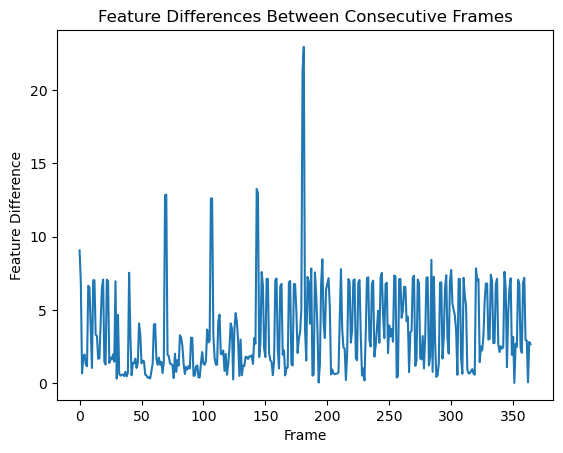

In [9]:
# Extract video features using ViViT
video_features = extract_vivit_features(preprocessed_frames)

# Detect scene transitions
scene_transition_indices = detect_scene_transitions(video_features)

# Cluster the scene transitions
clustered_scenes = cluster_scene_transitions(video_features, scene_transition_indices)

In [10]:
# Step 7: Object Detection with YOLOv5
yolo_model = YOLO("yolov5xu.pt").to(device)  # Replace "yolov5s.pt" with the correct path if necessary

def detect_objects_in_frame(frame):
    # YOLOv5 expects PIL images
    pil_frame = Image.fromarray(frame)
    results = yolo_model(pil_frame)
    detected_objects = []
    for result in results:
        for cls in result.boxes.cls:
            cls_name = yolo_model.names[int(cls)]
            detected_objects.append(cls_name)
    return detected_objects

In [11]:
# Step 8: Generate descriptions with YOLOv5 and BLIP
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large", load_in_8bit=True)

# blip_model.to(device)

blip_model.eval()

descriptions = []
for i, transition_frame in enumerate(clustered_scenes):
    key_frame = preprocessed_frames[transition_frame]
    # Convert back to HWC format and to uint8
    key_frame_img_uint8 = (key_frame * 255).astype(np.uint8).transpose(1, 2, 0)

    # Detect objects using YOLOv5
    detected_objects = detect_objects_in_frame(key_frame_img_uint8)

    # BLIP Description Generation
    inputs = blip_processor(images=key_frame_img_uint8, return_tensors="pt").to(device)

    # Modify the generation parameters to increase descriptiveness
    outputs = blip_model.generate(**inputs, max_new_tokens=250, num_beams=10, length_penalty=2.0, no_repeat_ngram_size=2)

    visual_description = blip_processor.decode(outputs[0], skip_special_tokens=True)

    # Combine detected objects and BLIP description
    combined_description = f"Objects detected: {', '.join(detected_objects)}. Visual: {visual_description}"

    descriptions.append(f"Scene {i+1}: {combined_description}")
    print(f"Description for Scene {i+1}: {combined_description}")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

c:\Users\farha\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\farha\.cache\huggingface\hub\models--Salesforce--blip-image-captioning-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BlipForConditionalGeneration were not initialized from the model checkpoint at Sales


0: 640x640 1 person, 27.0ms
Speed: 3.9ms preprocess, 27.0ms inference, 153.0ms postprocess per image at shape (1, 3, 640, 640)
Description for Scene 1: Objects detected: person. Visual: there is a woman that is standing in front of a projector screen with her hands on her hips and a black shirt and red skirt with a red and black top and white striped skirt and grey skirt are standing next to a man who is holding a white board that has his hand on his right hand in the other hand with his left side of his chest and he is wearing a gray shirt with black and blue and gray and the same pants and his shirt, and is his pants, a blue, he has a brown and there are a grey shirt that are both are his arms are on the bottom, with red, his legs, in his neck, both with the back, on him and her, while he are in a maroon and him is on, the right, her and with him with two legs and she is in her neck and on a neck with both, she are wearing his and are with?? is he? are, that his, is her with, are? a

In [12]:
# Step 9: Text Detection with Google Cloud Vision
def detect_text_from_frames(frame_folder):
    text_data = []
    client = vision.ImageAnnotatorClient()

    # Iterate over all frames in the folder
    for frame_file in os.listdir(frame_folder):
        frame_path = os.path.join(frame_folder, frame_file)

        # Read the frame image
        with open(frame_path, "rb") as image_file:
            content = image_file.read()

        # Perform text detection on the frame
        image = vision.Image(content=content)
        response = client.text_detection(image=image)
        texts = response.text_annotations

        # Collect all detected texts from this frame
        frame_texts = [text.description for text in texts]

        # Join all the detected text in this frame into a single string
        detected_text_str = " ".join(frame_texts)
        if detected_text_str:  # If there was any text detected
            text_data.append(f"Detected in {frame_file}: {detected_text_str}")

    return text_data

In [13]:
# Step 10: Combine Descriptions and Audio Transcription
video_transcript = transcribe_audio(video_path)  # Transcribe the video
detected_texts_from_frames = detect_text_from_frames("./video_frames")

100%|█████████████████████████████████████| 1.42G/1.42G [04:58<00:00, 5.12MiB/s]


In [14]:
# Meaningfully combine the transcript, descriptions, and detected text
combined_text = f"{video_transcript} {' '.join(descriptions)} {' '.join(detected_texts_from_frames)}"

In [17]:
# # DEBUGGING PURPOSES ONLY
save_path = "combined_text.txt"

# # Save the combined text.
# with open(save_path, "w") as f:
#     f.write(combined_text)

# Load the combined text.
with open(save_path, "r") as f:
    combined_text = f.read()

In [21]:
# Step 11: Final Summary using summarization model
model_name = "facebook/bart-large-cnn"  # Use mBART for summarization
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, load_in_8bit=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

summarizer = pipeline("summarization", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

In [22]:
summary_text = summarize_text(combined_text, summarizer)

In [23]:
print("Generated Summary:")
print(summary_text)

Generated Summary:
A policy is a set of actions that, uh, the agent should take in the world. Does anybody remember what a model was? Yeah. A model is like a representation of the world and how that changes in response to agents' actions. The reward model specifies what is the expected reward, um, that the agent receives from taking a particular action. How do we do the planning problem? So, we're not going to talk about learning today. We're just going to talks about the problem of figuring out what is the right thing to do. When your actions may have delayed consequences, which means that you may have to sacrifice immediate reward in order to maximize long-term reward. The Markov decision process is where we think about an agent interacting with the world. So, the agent gets to take actions typically denoted by A. Those affect the state of the world in some way, um, and then the agent receives back a state and a reward. A Markov chain is a sequence of random states where the transiti